In [1]:
# Cell 1: Installer les dépendances
!pip install optuna keras-tuner keras-tcn tensorflow-addons


In [2]:
# Cell 2: Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten,
    GRU, SimpleRNN, Dense, Dropout,
    MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.pruners import MedianPruner
import keras_tuner as kt
from tcn import TCN
import matplotlib.pyplot as plt


In [3]:
# Cell 3: Chargement et nettoyage des données
file_path = r"C:/Users/Mouhcine/Desktop/M_eco-main/M_eco-main/Dataset/Dataset_Timeseries.csv"
df = pd.read_csv(file_path)
# date → index
df.rename(columns={df.columns[0]:'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
# nettoyage numérique
num_cols = df.columns
df[num_cols] = df[num_cols].replace({' ': '', '\xa0': ''}, regex=True).astype(float)
df.ffill(inplace=True); df.bfill(inplace=True)


In [4]:
# Cell 4: Feature engineering basique
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)
df['dow_sin']   = np.sin(2*np.pi*df.index.dayofweek/7)
df['dow_cos']   = np.cos(2*np.pi*df.index.dayofweek/7)


In [5]:
# Cell 5: Split chronologique train / val / test
n = len(df)
train_end = int(n*0.7)
val_end   = int(n*0.85)
train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]


In [6]:
# Cell 6: Scaling (fit sur train uniquement)
scaler = MinMaxScaler().fit(train_df)


In [7]:
# Cell 7: Création des séquences temporelles
def make_sequences(df_):
    arr = scaler.transform(df_)
    X, y = [], []
    SEQ = 30
    for i in range(len(arr)-SEQ):
        X.append(arr[i:i+SEQ])
        y.append(arr[i+SEQ,:len(num_cols)])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_df)
X_val,   y_val   = make_sequences(pd.concat([train_df.iloc[-30:], val_df]))
X_test,  y_test  = make_sequences(pd.concat([val_df.iloc[-30:], test_df]))
n_features = X_train.shape[2]


In [8]:
# Cell 8: Walk-Forward CV utilitaire
def walk_forward_cv(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(X):
        yield X[tr], y[tr], X[te], y[te]


In [9]:
# Cell 9: Définition des build_functions pour les 7 modèles
def build_lstm(trial):
    u   = trial.suggest_int("units", 32,256)
    d   = trial.suggest_float("dropout",0,0.5)
    L   = trial.suggest_int("n_layers",1,3)
    m   = Sequential([Input((30,n_features))])
    for i in range(L):
        rs = i< L-1
        m.add(LSTM(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols)))
    m.compile("adam","mse"); return m

def build_bilstm(trial):
    u   = trial.suggest_int("units",32,256)
    d   = trial.suggest_float("dropout",0,0.5)
    L   = trial.suggest_int("n_layers",1,3)
    m   = Sequential([Input((30,n_features))])
    for i in range(L):
        rs = i< L-1
        m.add(Bidirectional(LSTM(u,return_sequences=rs)))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols)))
    m.compile("adam","mse"); return m

def build_lstm_cnn(trial):
    lu  = trial.suggest_int("lstm_units",32,256)
    cf  = trial.suggest_int("cnn_filters",16,128)
    ks  = trial.suggest_int("kernel_size",2,5)
    d   = trial.suggest_float("dropout",0,0.5)
    inp=Input((30,n_features))
    x = LSTM(lu,return_sequences=True)(inp)
    x = Conv1D(cf,ks,activation="relu")(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x); x = Dropout(d)(x)
    out= Dense(len(num_cols))(x)
    m=Model(inp,out); m.compile("adam","mse"); return m

def build_gru(trial):
    u=trial.suggest_int("units",32,256)
    d=trial.suggest_float("dropout",0,0.5)
    L=trial.suggest_int("n_layers",1,3)
    m=Sequential([Input((30,n_features))])
    for i in range(L):
        rs=i< L-1
        m.add(GRU(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols))); m.compile("adam","mse"); return m

def build_rnn(trial):
    u=trial.suggest_int("units",32,256)
    d=trial.suggest_float("dropout",0,0.5)
    L=trial.suggest_int("n_layers",1,3)
    m=Sequential([Input((30,n_features))])
    for i in range(L):
        rs=i< L-1
        m.add(SimpleRNN(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols))); m.compile("adam","mse"); return m

def build_tcn(trial):
    f=trial.suggest_int("filters",16,128)
    ks=trial.suggest_int("kernel_size",2,5)
    d=trial.suggest_float("dropout",0,0.5)
    inp=Input((30,n_features))
    x = TCN(nb_filters=f,kernel_size=ks,dilations=[1,2,4],dropout_rate=d)(inp)
    out= Dense(len(num_cols))(x)
    m=Model(inp,out); m.compile("adam","mse"); return m

# Cell 9 (modifiée) : Définition des build_functions pour les 7 modèles,
# avec build_transformer corrigé

def build_transformer(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(30, n_features))
    # 1) Self-attention
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)

    # 2) Residual + Norm (attention)
    x1 = Add()([inp, attn])
    x1 = LayerNormalization(epsilon=1e-6)(x1)

    # 3) Feed-forward on last dim d_model
    ffn = Dense(ff_dim, activation="relu")(x1)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(d_model)(ffn)  # <-- on ramène à d_model, pas à len(num_cols)

    # 4) Residual + Norm (FFN)
    x2 = Add()([x1, ffn])
    x2 = LayerNormalization(epsilon=1e-6)(x2)

    # 5) Flatten & projection finale vers len(num_cols)
    flat = Flatten()(x2)
    out  = Dense(len(num_cols), activation="linear")(flat)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model



In [10]:
# Cell 10a: Coarse tuning Optuna pour LSTM
import os
import pickle
from sklearn.metrics import mean_squared_error

def objective_lstm(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_lstm(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_lstm.optimize(objective_lstm, n_trials=20)
best_params_lstm = study_lstm.best_trial.params
print("Best LSTM params:", best_params_lstm)



# Créer le dossier s'il n'existe pas
os.makedirs('optuna_studies', exist_ok=True)

# Sauvegarder l'étude Optuna
with open('optuna_studies/study_lstm.pkl', 'wb') as f:
    pickle.dump(study_lstm, f)
print("LSTM study saved to: optuna_studies/study_lstm.pkl")

# Entraîner et sauvegarder le meilleur modèle LSTM
best_trial = optuna.trial.FixedTrial(best_params_lstm)
best_lstm_model = build_lstm(best_trial)
best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_lstm_model.save('optuna_studies/best_lstm_model.h5')
print("Best LSTM model saved to: optuna_studies/best_lstm_model.h5")


[I 2025-06-14 01:58:27,046] A new study created in memory with name: no-name-629134b7-42de-4d92-ac6c-fff83e781510


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020F256B6F20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-06-14 01:59:04,604] Trial 0 finished with value: 0.03433583612990828 and parameters: {'units': 182, 'dropout': 0.44720528744028964, 'n_layers': 2}. Best is trial 0 with value: 0.03433583612990828.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step


[I 2025-06-14 01:59:39,875] Trial 1 finished with value: 0.03469824789773984 and parameters: {'units': 126, 'dropout': 0.12911187102447463, 'n_layers': 2}. Best is trial 0 with value: 0.03433583612990828.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step


[I 2025-06-14 02:00:26,631] Trial 2 finished with value: 0.0339404316182363 and parameters: {'units': 160, 'dropout': 0.09598167384130529, 'n_layers': 2}. Best is trial 2 with value: 0.0339404316182363.


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 985ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step


[I 2025-06-14 02:01:43,225] Trial 3 finished with value: 0.03742067482612987 and parameters: {'units': 74, 'dropout': 0.4950997857658441, 'n_layers': 3}. Best is trial 2 with value: 0.0339404316182363.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


[I 2025-06-14 02:02:07,682] Trial 4 finished with value: 0.036258679117509275 and parameters: {'units': 181, 'dropout': 0.4853193184730763, 'n_layers': 1}. Best is trial 2 with value: 0.0339404316182363.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step


[I 2025-06-14 02:02:45,108] Trial 5 finished with value: 0.0317321404985306 and parameters: {'units': 221, 'dropout': 0.3427975698362827, 'n_layers': 2}. Best is trial 5 with value: 0.0317321404985306.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 710ms/step


[I 2025-06-14 02:03:01,301] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


[I 2025-06-14 02:03:06,805] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step


[I 2025-06-14 02:03:23,356] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step


[I 2025-06-14 02:03:35,447] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step


[I 2025-06-14 02:03:41,745] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-06-14 02:03:49,761] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step


[I 2025-06-14 02:04:21,162] Trial 12 finished with value: 0.03494895212103075 and parameters: {'units': 185, 'dropout': 0.0966556450687181, 'n_layers': 2}. Best is trial 5 with value: 0.0317321404985306.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


[I 2025-06-14 02:04:28,624] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step


[I 2025-06-14 02:04:40,924] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step


[I 2025-06-14 02:04:46,384] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-06-14 02:04:56,363] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-06-14 02:05:03,245] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 602ms/step


[I 2025-06-14 02:05:22,180] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step


[I 2025-06-14 02:05:30,861] Trial 19 pruned. 


Best LSTM params: {'units': 221, 'dropout': 0.3427975698362827, 'n_layers': 2}
LSTM study saved to: optuna_studies/study_lstm.pkl


Best LSTM model saved to: optuna_studies/best_lstm_model.h5


In [11]:
# Cell 10b: Coarse tuning Optuna pour BiLSTM

def objective_bilstm(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_bilstm(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_bilstm = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_bilstm.optimize(objective_bilstm, n_trials=20)
best_params_bilstm = study_bilstm.best_trial.params
print("Best BiLSTM params:", best_params_bilstm)

# Sauvegarder l'étude Optuna
with open('optuna_studies/study_bilstm.pkl', 'wb') as f:
    pickle.dump(study_bilstm, f)
print("BiLSTM study saved to: optuna_studies/study_bilstm.pkl")

# Entraîner et sauvegarder le meilleur modèle BiLSTM
best_trial = optuna.trial.FixedTrial(best_params_bilstm)
best_bilstm_model = build_bilstm(best_trial)
best_bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_bilstm_model.save('optuna_studies/best_bilstm_model.h5')
print("Best BiLSTM model saved to: optuna_studies/best_bilstm_model.h5")


[I 2025-06-14 02:06:28,775] A new study created in memory with name: no-name-10db017c-234a-492e-87f2-11cef57b98aa


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step 


[I 2025-06-14 02:08:08,346] Trial 0 finished with value: 0.03570003207576703 and parameters: {'units': 130, 'dropout': 0.04476733830759194, 'n_layers': 2}. Best is trial 0 with value: 0.03570003207576703.


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step


[I 2025-06-14 02:09:02,490] Trial 1 finished with value: 0.03471457698690846 and parameters: {'units': 174, 'dropout': 0.26558422448627667, 'n_layers': 2}. Best is trial 1 with value: 0.03471457698690846.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step


[I 2025-06-14 02:09:35,022] Trial 2 finished with value: 0.03346635239874097 and parameters: {'units': 210, 'dropout': 0.20950796933478666, 'n_layers': 2}. Best is trial 2 with value: 0.03346635239874097.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step


[I 2025-06-14 02:10:07,791] Trial 3 finished with value: 0.0347330314515632 and parameters: {'units': 200, 'dropout': 0.2708687975727869, 'n_layers': 2}. Best is trial 2 with value: 0.03346635239874097.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


[I 2025-06-14 02:10:36,582] Trial 4 finished with value: 0.03566780117400537 and parameters: {'units': 86, 'dropout': 0.24576406380033322, 'n_layers': 2}. Best is trial 2 with value: 0.03346635239874097.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step


[I 2025-06-14 02:10:50,143] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step


[I 2025-06-14 02:11:05,205] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 909ms/step


[I 2025-06-14 02:11:21,217] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


[I 2025-06-14 02:11:25,947] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step


[I 2025-06-14 02:12:07,240] Trial 9 finished with value: 0.03350739561726854 and parameters: {'units': 107, 'dropout': 0.4345846267559821, 'n_layers': 3}. Best is trial 2 with value: 0.03346635239874097.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


[I 2025-06-14 02:12:15,347] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step


[I 2025-06-14 02:12:57,848] Trial 11 finished with value: 0.03382363370741908 and parameters: {'units': 102, 'dropout': 0.4944161025903257, 'n_layers': 3}. Best is trial 2 with value: 0.03346635239874097.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


[I 2025-06-14 02:13:02,693] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step


[I 2025-06-14 02:13:11,647] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step


[I 2025-06-14 02:13:24,411] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step


[I 2025-06-14 02:13:37,075] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step


[I 2025-06-14 02:13:51,414] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


[I 2025-06-14 02:13:56,241] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step


[I 2025-06-14 02:14:26,634] Trial 18 finished with value: 0.03543249609512858 and parameters: {'units': 67, 'dropout': 0.4408102113434769, 'n_layers': 2}. Best is trial 2 with value: 0.03346635239874097.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step


[I 2025-06-14 02:14:41,182] Trial 19 pruned. 


Best BiLSTM params: {'units': 210, 'dropout': 0.20950796933478666, 'n_layers': 2}
BiLSTM study saved to: optuna_studies/study_bilstm.pkl


Best BiLSTM model saved to: optuna_studies/best_bilstm_model.h5


In [12]:
# Cell 10c: Coarse tuning Optuna pour LSTM-CNN

def objective_lstm_cnn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_lstm_cnn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm_cnn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_lstm_cnn.optimize(objective_lstm_cnn, n_trials=20)
best_params_lstm_cnn = study_lstm_cnn.best_trial.params
print("Best LSTM-CNN params:", best_params_lstm_cnn)

# Sauvegarder l'étude Optuna
with open('optuna_studies/study_lstm_cnn.pkl', 'wb') as f:
    pickle.dump(study_lstm_cnn, f)
print("LSTM-CNN study saved to: optuna_studies/study_lstm_cnn.pkl")

# Entraîner et sauvegarder le meilleur modèle LSTM-CNN
best_trial = optuna.trial.FixedTrial(best_params_lstm_cnn)
best_lstm_cnn_model = build_lstm_cnn(best_trial)
best_lstm_cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_lstm_cnn_model.save('optuna_studies/best_lstm_cnn_model.h5')
print("Best LSTM-CNN model saved to: optuna_studies/best_lstm_cnn_model.h5")


[I 2025-06-14 02:15:55,765] A new study created in memory with name: no-name-46982b87-cd05-4c4c-89ae-8dbd19bb384f


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-06-14 02:16:06,944] Trial 0 finished with value: 0.034715157910546725 and parameters: {'lstm_units': 251, 'cnn_filters': 89, 'kernel_size': 5, 'dropout': 0.06776568654464438}. Best is trial 0 with value: 0.034715157910546725.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


[I 2025-06-14 02:16:21,408] Trial 1 finished with value: 0.037877295507046514 and parameters: {'lstm_units': 131, 'cnn_filters': 35, 'kernel_size': 4, 'dropout': 0.4863760147941871}. Best is trial 0 with value: 0.034715157910546725.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-06-14 02:16:31,926] Trial 2 finished with value: 0.03369465404416349 and parameters: {'lstm_units': 182, 'cnn_filters': 92, 'kernel_size': 3, 'dropout': 0.30358290008441935}. Best is trial 2 with value: 0.03369465404416349.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-06-14 02:16:42,309] Trial 3 finished with value: 0.03535773505306621 and parameters: {'lstm_units': 126, 'cnn_filters': 67, 'kernel_size': 5, 'dropout': 0.14890842109969504}. Best is trial 2 with value: 0.03369465404416349.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


[I 2025-06-14 02:16:52,125] Trial 4 finished with value: 0.034899450978196384 and parameters: {'lstm_units': 88, 'cnn_filters': 96, 'kernel_size': 2, 'dropout': 0.1643246726050292}. Best is trial 2 with value: 0.03369465404416349.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-06-14 02:16:55,659] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-06-14 02:16:59,324] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-06-14 02:17:06,187] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-06-14 02:17:09,356] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-06-14 02:17:24,182] Trial 9 finished with value: 0.034321203098592074 and parameters: {'lstm_units': 112, 'cnn_filters': 122, 'kernel_size': 2, 'dropout': 0.37445324991428075}. Best is trial 2 with value: 0.03369465404416349.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-06-14 02:17:31,806] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-06-14 02:17:41,888] Trial 11 finished with value: 0.034330871020481844 and parameters: {'lstm_units': 165, 'cnn_filters': 124, 'kernel_size': 2, 'dropout': 0.35576574208757794}. Best is trial 2 with value: 0.03369465404416349.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-06-14 02:17:49,005] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-06-14 02:17:55,789] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-06-14 02:17:59,171] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-06-14 02:18:02,520] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-06-14 02:18:05,866] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-06-14 02:18:09,303] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-06-14 02:18:24,319] Trial 18 finished with value: 0.03363338696891018 and parameters: {'lstm_units': 219, 'cnn_filters': 115, 'kernel_size': 2, 'dropout': 0.30517285278236284}. Best is trial 18 with value: 0.03363338696891018.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-06-14 02:18:35,018] Trial 19 finished with value: 0.033551166248276004 and parameters: {'lstm_units': 232, 'cnn_filters': 113, 'kernel_size': 3, 'dropout': 0.20134901918163875}. Best is trial 19 with value: 0.033551166248276004.


Best LSTM-CNN params: {'lstm_units': 232, 'cnn_filters': 113, 'kernel_size': 3, 'dropout': 0.20134901918163875}
LSTM-CNN study saved to: optuna_studies/study_lstm_cnn.pkl


Best LSTM-CNN model saved to: optuna_studies/best_lstm_cnn_model.h5


In [13]:
# Cell 10d: Coarse tuning Optuna pour GRU

def objective_gru(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_gru(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_gru = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_gru.optimize(objective_gru, n_trials=20)
best_params_gru = study_gru.best_trial.params
print("Best GRU params:", best_params_gru)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_gru.pkl', 'wb') as f:
    pickle.dump(study_gru, f)
print("GRU study saved to: optuna_studies/study_gru.pkl")

# Entraîner et sauvegarder le meilleur modèle GRU
best_trial = optuna.trial.FixedTrial(best_params_gru)
best_gru_model = build_gru(best_trial)
best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_gru_model.save('optuna_studies/best_gru_model.h5')
print("Best GRU model saved to: optuna_studies/best_gru_model.h5")


[I 2025-06-14 02:18:52,018] A new study created in memory with name: no-name-85c698ec-85df-4da9-a710-6b1f4104fd14


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-06-14 02:19:01,602] Trial 0 finished with value: 0.038837790221956776 and parameters: {'units': 119, 'dropout': 0.10243097621666025, 'n_layers': 1}. Best is trial 0 with value: 0.038837790221956776.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-06-14 02:19:12,016] Trial 1 finished with value: 0.049009540059271765 and parameters: {'units': 71, 'dropout': 0.265319802277684, 'n_layers': 1}. Best is trial 0 with value: 0.038837790221956776.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-06-14 02:19:21,654] Trial 2 finished with value: 0.0439474419916572 and parameters: {'units': 94, 'dropout': 0.19223913830490963, 'n_layers': 1}. Best is trial 0 with value: 0.038837790221956776.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-06-14 02:19:51,764] Trial 3 finished with value: 0.0353930394080802 and parameters: {'units': 113, 'dropout': 0.38573419427734984, 'n_layers': 3}. Best is trial 3 with value: 0.0353930394080802.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-06-14 02:20:15,929] Trial 4 finished with value: 0.03451429023594218 and parameters: {'units': 108, 'dropout': 0.4665320305439585, 'n_layers': 3}. Best is trial 4 with value: 0.03451429023594218.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


[I 2025-06-14 02:20:34,128] Trial 5 finished with value: 0.03468386476921984 and parameters: {'units': 235, 'dropout': 0.1839264522955995, 'n_layers': 2}. Best is trial 4 with value: 0.03451429023594218.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[I 2025-06-14 02:20:44,377] Trial 6 finished with value: 0.0328439935099032 and parameters: {'units': 248, 'dropout': 0.32470978937143674, 'n_layers': 1}. Best is trial 6 with value: 0.0328439935099032.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


[I 2025-06-14 02:21:00,401] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-06-14 02:21:26,358] Trial 8 finished with value: 0.03434360121877725 and parameters: {'units': 143, 'dropout': 0.2753384598733412, 'n_layers': 3}. Best is trial 6 with value: 0.0328439935099032.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


[I 2025-06-14 02:21:44,491] Trial 9 finished with value: 0.03246172784110843 and parameters: {'units': 148, 'dropout': 0.0779202036893098, 'n_layers': 2}. Best is trial 9 with value: 0.03246172784110843.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step


[I 2025-06-14 02:22:08,122] Trial 10 finished with value: 0.031347563388371406 and parameters: {'units': 188, 'dropout': 0.0023532864657948294, 'n_layers': 2}. Best is trial 10 with value: 0.031347563388371406.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


[I 2025-06-14 02:22:14,205] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-06-14 02:22:33,909] Trial 12 finished with value: 0.03193705950070599 and parameters: {'units': 186, 'dropout': 0.007446038518090985, 'n_layers': 2}. Best is trial 10 with value: 0.031347563388371406.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


[I 2025-06-14 02:22:52,592] Trial 13 finished with value: 0.03295551359174001 and parameters: {'units': 196, 'dropout': 0.022139909537425666, 'n_layers': 2}. Best is trial 10 with value: 0.031347563388371406.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


[I 2025-06-14 02:22:58,253] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-06-14 02:23:26,501] Trial 15 finished with value: 0.03225195767420283 and parameters: {'units': 219, 'dropout': 0.10722023872489359, 'n_layers': 3}. Best is trial 10 with value: 0.031347563388371406.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step


[I 2025-06-14 02:23:38,720] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-06-14 02:23:47,216] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


[I 2025-06-14 02:23:53,508] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-06-14 02:23:57,649] Trial 19 pruned. 


Best GRU params: {'units': 188, 'dropout': 0.0023532864657948294, 'n_layers': 2}
GRU study saved to: optuna_studies/study_gru.pkl


Best GRU model saved to: optuna_studies/best_gru_model.h5


In [14]:
# Cell 10e: Coarse tuning Optuna pour RNN

def objective_rnn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_rnn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_rnn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_rnn.optimize(objective_rnn, n_trials=20)
best_params_rnn = study_rnn.best_trial.params
print("Best RNN params:", best_params_rnn)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_rnn.pkl', 'wb') as f:
    pickle.dump(study_rnn, f)
print("RNN study saved to: optuna_studies/study_rnn.pkl")

# Entraîner et sauvegarder le meilleur modèle RNN
best_trial = optuna.trial.FixedTrial(best_params_rnn)
best_rnn_model = build_rnn(best_trial)
best_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_rnn_model.save('optuna_studies/best_rnn_model.h5')
print("Best RNN model saved to: optuna_studies/best_rnn_model.h5")


[I 2025-06-14 02:24:29,931] A new study created in memory with name: no-name-7b02b629-32be-473c-98e8-6a5a6e460ac1


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-06-14 02:24:37,953] Trial 0 finished with value: 0.08452250200023692 and parameters: {'units': 217, 'dropout': 0.46933873309404545, 'n_layers': 1}. Best is trial 0 with value: 0.08452250200023692.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-06-14 02:24:46,196] Trial 1 finished with value: 0.1835357198732117 and parameters: {'units': 65, 'dropout': 0.3200987981312887, 'n_layers': 1}. Best is trial 0 with value: 0.08452250200023692.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


[I 2025-06-14 02:24:59,436] Trial 2 finished with value: 0.14478906585867587 and parameters: {'units': 217, 'dropout': 0.1613122879297278, 'n_layers': 2}. Best is trial 0 with value: 0.08452250200023692.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-06-14 02:25:07,545] Trial 3 finished with value: 0.07850238815276002 and parameters: {'units': 252, 'dropout': 0.31307551542555223, 'n_layers': 1}. Best is trial 3 with value: 0.07850238815276002.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-06-14 02:25:15,578] Trial 4 finished with value: 0.11353848109089004 and parameters: {'units': 72, 'dropout': 0.009621494081971826, 'n_layers': 1}. Best is trial 3 with value: 0.07850238815276002.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


[I 2025-06-14 02:25:21,930] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step


[I 2025-06-14 02:25:27,961] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-06-14 02:25:47,926] Trial 7 finished with value: 0.06892501439788178 and parameters: {'units': 219, 'dropout': 0.03148802934555395, 'n_layers': 1}. Best is trial 7 with value: 0.06892501439788178.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 850ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-06-14 02:25:57,026] Trial 8 finished with value: 0.07727752645241727 and parameters: {'units': 196, 'dropout': 0.003233903223252843, 'n_layers': 1}. Best is trial 7 with value: 0.06892501439788178.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-06-14 02:25:59,510] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2025-06-14 02:26:03,625] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


[I 2025-06-14 02:26:07,779] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-06-14 02:26:15,558] Trial 12 finished with value: 0.07178088797894833 and parameters: {'units': 253, 'dropout': 0.007157884129055173, 'n_layers': 1}. Best is trial 7 with value: 0.06892501439788178.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


[I 2025-06-14 02:26:20,691] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-06-14 02:26:28,540] Trial 14 finished with value: 0.07666964751706092 and parameters: {'units': 230, 'dropout': 0.21585697047218197, 'n_layers': 1}. Best is trial 7 with value: 0.06892501439788178.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


[I 2025-06-14 02:26:32,996] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-06-14 02:26:35,540] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


[I 2025-06-14 02:26:41,324] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-06-14 02:26:49,077] Trial 18 finished with value: 0.06695486037408051 and parameters: {'units': 204, 'dropout': 0.0504187469012259, 'n_layers': 1}. Best is trial 18 with value: 0.06695486037408051.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-06-14 02:26:53,389] Trial 19 pruned. 


Best RNN params: {'units': 204, 'dropout': 0.0504187469012259, 'n_layers': 1}
RNN study saved to: optuna_studies/study_rnn.pkl


Best RNN model saved to: optuna_studies/best_rnn_model.h5


In [15]:
# Cell 10f: Coarse tuning Optuna pour TCN

def objective_tcn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_tcn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_tcn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_tcn.optimize(objective_tcn, n_trials=20)
best_params_tcn = study_tcn.best_trial.params
print("Best TCN params:", best_params_tcn)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_tcn.pkl', 'wb') as f:
    pickle.dump(study_tcn, f)
print("TCN study saved to: optuna_studies/study_tcn.pkl")

# Entraîner et sauvegarder le meilleur modèle TCN
best_trial = optuna.trial.FixedTrial(best_params_tcn)
best_tcn_model = build_tcn(best_trial)
best_tcn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_tcn_model.save_weights('optuna_studies/best_tcn_weights.weights.h5')
print("Best TCN model saved to: optuna_studies/best_tcn_model.h5")


[I 2025-06-14 02:27:00,272] A new study created in memory with name: no-name-a42d1fd2-5bf0-4316-8d8b-42063e2485fc


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step


[I 2025-06-14 02:27:22,514] Trial 0 finished with value: 0.26613398411229633 and parameters: {'filters': 41, 'kernel_size': 4, 'dropout': 0.26779221574479495}. Best is trial 0 with value: 0.26613398411229633.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-06-14 02:28:02,668] Trial 1 finished with value: 0.33860418738743 and parameters: {'filters': 22, 'kernel_size': 3, 'dropout': 0.011846300094133011}. Best is trial 0 with value: 0.26613398411229633.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2025-06-14 02:28:19,573] Trial 2 finished with value: 0.16351948715998907 and parameters: {'filters': 106, 'kernel_size': 3, 'dropout': 0.1986011856704154}. Best is trial 2 with value: 0.16351948715998907.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


[I 2025-06-14 02:28:36,949] Trial 3 finished with value: 0.23858633300253826 and parameters: {'filters': 98, 'kernel_size': 2, 'dropout': 0.3255936460802148}. Best is trial 2 with value: 0.16351948715998907.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-06-14 02:28:57,815] Trial 4 finished with value: 0.18864515374910926 and parameters: {'filters': 108, 'kernel_size': 2, 'dropout': 0.006427858301801037}. Best is trial 2 with value: 0.16351948715998907.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


[I 2025-06-14 02:29:18,152] Trial 5 finished with value: 0.1870019985990704 and parameters: {'filters': 80, 'kernel_size': 3, 'dropout': 0.18493457312898753}. Best is trial 2 with value: 0.16351948715998907.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 13s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step


[I 2025-06-14 02:30:02,187] Trial 6 finished with value: 0.11795211279748435 and parameters: {'filters': 124, 'kernel_size': 5, 'dropout': 0.368814263690989}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


[I 2025-06-14 02:30:15,080] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


[I 2025-06-14 02:30:22,980] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


[I 2025-06-14 02:30:28,907] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


[I 2025-06-14 02:30:51,742] Trial 10 finished with value: 0.12946451631530945 and parameters: {'filters': 125, 'kernel_size': 5, 'dropout': 0.47200516780533874}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-06-14 02:31:09,023] Trial 11 finished with value: 0.1579347188716795 and parameters: {'filters': 127, 'kernel_size': 5, 'dropout': 0.49282821473399335}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2025-06-14 02:31:27,893] Trial 12 finished with value: 0.1303495436901494 and parameters: {'filters': 125, 'kernel_size': 5, 'dropout': 0.46337158080232854}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-06-14 02:32:16,931] Trial 13 finished with value: 0.13404141987707485 and parameters: {'filters': 128, 'kernel_size': 5, 'dropout': 0.4036564523699203}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


[I 2025-06-14 02:32:22,537] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-06-14 02:32:28,521] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-06-14 02:32:46,290] Trial 16 finished with value: 0.13292978729968544 and parameters: {'filters': 117, 'kernel_size': 5, 'dropout': 0.4467462467419818}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-06-14 02:33:02,754] Trial 17 finished with value: 0.13933772131847363 and parameters: {'filters': 109, 'kernel_size': 5, 'dropout': 0.3577124347525368}. Best is trial 6 with value: 0.11795211279748435.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-06-14 02:33:08,188] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


[I 2025-06-14 02:33:27,967] Trial 19 finished with value: 0.1324661861190276 and parameters: {'filters': 93, 'kernel_size': 5, 'dropout': 0.23698738186724355}. Best is trial 6 with value: 0.11795211279748435.


Best TCN params: {'filters': 124, 'kernel_size': 5, 'dropout': 0.368814263690989}
TCN study saved to: optuna_studies/study_tcn.pkl
Best TCN model saved to: optuna_studies/best_tcn_model.h5


In [16]:
# Cell 10g: Coarse tuning Optuna pour Transformer (avec build_transformer corrigé)

import numpy as np
from sklearn.metrics import mean_squared_error

# On redéfinit build_transformer pour assurer des shapes compatibles
def build_transformer(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(30, n_features))
    # Self-attention (sortie reste de dim n_features)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)
    x1   = Add()([inp, attn])
    x1   = LayerNormalization(epsilon=1e-6)(x1)

    # FFN projeté sur n_features pour pouvoir résiduel sur x1
    ffn  = Dense(ff_dim, activation="relu")(x1)
    ffn  = Dropout(dropout)(ffn)
    ffn  = Dense(n_features)(ffn)
    x2   = Add()([x1, ffn])
    x2   = LayerNormalization(epsilon=1e-6)(x2)

    # Flatten + dernière projection
    flat = Flatten()(x2)
    out  = Dense(len(num_cols), activation="linear")(flat)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_transformer(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_transformer(trial)
        m.fit(
            Xt, yt,
            validation_data=(Xv, yv),
            epochs=30, batch_size=32,
            callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
            verbose=0
        )
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_transformer = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_transformer.optimize(objective_transformer, n_trials=20)
best_params_transformer = study_transformer.best_trial.params
print("Best Transformer params:", best_params_transformer)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_transformer.pkl', 'wb') as f:
    pickle.dump(study_transformer, f)
print("Transformer study saved to: optuna_studies/study_transformer.pkl")

# Entraîner et sauvegarder le meilleur modèle Transformer
best_trial = optuna.trial.FixedTrial(best_params_transformer)
best_transformer_model = build_transformer(best_trial)
best_transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_transformer_model.save('optuna_studies/best_transformer_model.h5')
print("Best Transformer model saved to: optuna_studies/best_transformer_model.h5")

[I 2025-06-14 02:33:48,971] A new study created in memory with name: no-name-91877b2d-eb96-4773-9fa5-e61d77e8e2ee


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-06-14 02:34:08,756] Trial 0 finished with value: 0.5677472628404387 and parameters: {'d_model': 69, 'num_heads': 4, 'ff_dim': 118, 'dropout': 0.4924653798058442}. Best is trial 0 with value: 0.5677472628404387.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-06-14 02:35:03,127] Trial 1 finished with value: 0.4895800189756454 and parameters: {'d_model': 96, 'num_heads': 4, 'ff_dim': 75, 'dropout': 0.3041229829089489}. Best is trial 1 with value: 0.4895800189756454.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-06-14 02:35:22,740] Trial 2 finished with value: 0.6441130367723057 and parameters: {'d_model': 32, 'num_heads': 3, 'ff_dim': 40, 'dropout': 0.1557411118282725}. Best is trial 1 with value: 0.4895800189756454.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-06-14 02:35:45,735] Trial 3 finished with value: 0.7420644952004732 and parameters: {'d_model': 50, 'num_heads': 2, 'ff_dim': 125, 'dropout': 0.28938625290139836}. Best is trial 1 with value: 0.4895800189756454.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-06-14 02:36:02,611] Trial 4 finished with value: 0.5727339289747942 and parameters: {'d_model': 47, 'num_heads': 3, 'ff_dim': 87, 'dropout': 0.016537382635017417}. Best is trial 1 with value: 0.4895800189756454.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2025-06-14 02:36:23,094] Trial 5 finished with value: 0.5395132424859993 and parameters: {'d_model': 46, 'num_heads': 3, 'ff_dim': 110, 'dropout': 0.1818809693023608}. Best is trial 1 with value: 0.4895800189756454.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-06-14 02:36:28,493] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-06-14 02:36:46,506] Trial 7 finished with value: 0.4573074445134023 and parameters: {'d_model': 82, 'num_heads': 4, 'ff_dim': 92, 'dropout': 0.09392462616580105}. Best is trial 7 with value: 0.4573074445134023.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-06-14 02:36:51,725] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-06-14 02:37:40,791] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


[I 2025-06-14 02:37:50,773] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-06-14 02:37:56,622] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-06-14 02:38:14,449] Trial 12 finished with value: 0.47374741084180233 and parameters: {'d_model': 114, 'num_heads': 4, 'ff_dim': 97, 'dropout': 0.3147309353326364}. Best is trial 7 with value: 0.4573074445134023.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-06-14 02:38:21,811] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-06-14 02:38:27,555] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-06-14 02:38:33,298] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


[I 2025-06-14 02:38:40,401] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-06-14 02:38:47,357] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-06-14 02:38:55,203] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-06-14 02:39:07,130] Trial 19 pruned. 


Best Transformer params: {'d_model': 82, 'num_heads': 4, 'ff_dim': 92, 'dropout': 0.09392462616580105}
Transformer study saved to: optuna_studies/study_transformer.pkl


Best Transformer model saved to: optuna_studies/best_transformer_model.h5


In [17]:
# Cell 11: Entraînement final & sélection du meilleur modèle par indicateur

# (Re)définition du mapping nom → fonction de construction
builders = {
    'LSTM':        build_lstm,
    'BiLSTM':      build_bilstm,
    'LSTM-CNN':    build_lstm_cnn,
    'GRU':         build_gru,
    'RNN':         build_rnn,
    'TCN':         build_tcn,
    'Transformer': build_transformer
}

# best_params_<model> doivent déjà exister de vos cellules 10a–10g
best_params = {
    'LSTM':        best_params_lstm,
    'BiLSTM':      best_params_bilstm,
    'LSTM-CNN':    best_params_lstm_cnn,
    'GRU':         best_params_gru,
    'RNN':         best_params_rnn,
    'TCN':         best_params_tcn,
    'Transformer': best_params_transformer
}

# 1) Réentraîner chaque modèle sur train+val
final_models = {}
for name, build_fn in builders.items():
    trial = optuna.trial.FixedTrial(best_params[name])
    m = build_fn(trial)
    m.fit(
        np.vstack([X_train, X_val]),
        np.vstack([y_train, y_val]),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
        verbose=0
    )
    final_models[name] = m

# 2) Choisir, pour chaque indicateur, le modèle qui minimise la MSE sur le test
best_model_per_col = {}
for i, col in enumerate(num_cols):
    best_model_per_col[col] = min(
        final_models.keys(),
        key=lambda nm: mean_squared_error(
            y_test[:, i],
            final_models[nm].predict(X_test)[:, i]
        )
    )

print("Meilleur modèle par indicateur :")
for col, mdl in best_model_per_col.items():
    print(f"  {col:20s}: {mdl}")


c:\Users\Mouhcine\anaconda3\Nouveau dossier\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━

In [18]:
# Cell 12: Calcul des métriques en excluant les zéros (par indicateur)

# Récupérer les paramètres de scaling pour les cibles
target_dims = len(num_cols)
mins   = scaler.min_[:target_dims]
scales = scaler.scale_[:target_dims]

# Inversion manuelle du scaling sur y_test et preds
y_true = (y_test - mins) / scales

print("Métriques (excluant 0) par indicateur :")
for i, col in enumerate(num_cols):
    m = final_models[best_model_per_col[col]]
    preds_scaled = m.predict(X_test)[:, i]
    preds = (preds_scaled - mins[i]) / scales[i]

    mask = y_true[:, i] != 0
    mse = mean_squared_error(y_true[mask, i], preds[mask])
    mae = mean_absolute_error (y_true[mask, i], preds[mask])
    print(f"{col:20s} → MSE: {int(mse)}, MAE: {int(mae)}")


Métriques (excluant 0) par indicateur :
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
IDE(USD)             → MSE: 732950190680806272, MAE: 627372126
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
REER(2010 = 100)     → MSE: 223, MAE: 14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
brent_oil_prices(USD/barrel) → MSE: 584, MAE: 15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
crude_oil_prices(USD/barrel) → MSE: 90, MAE: 6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
daily_natural_gas_prices(USD/MMBtu) → MSE: 1, MAE: 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
annual_gold_prices(USD/oz) → MSE: 16524, MAE: 90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
wheat_production (Million Bushels) → MSE: 203850, MAE: 420
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
InterTourismeReceipts(usd) → MSE: 3924488316991565824, MAE: 1237804832
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Inflation, prix à la consommation (% annuel) → MSE: 5, MAE: 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Chômage, total (% de la population) → MSE: 1, MAE: 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


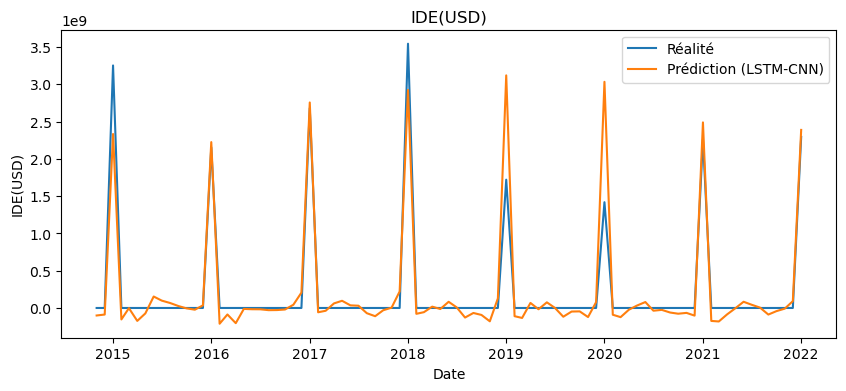

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


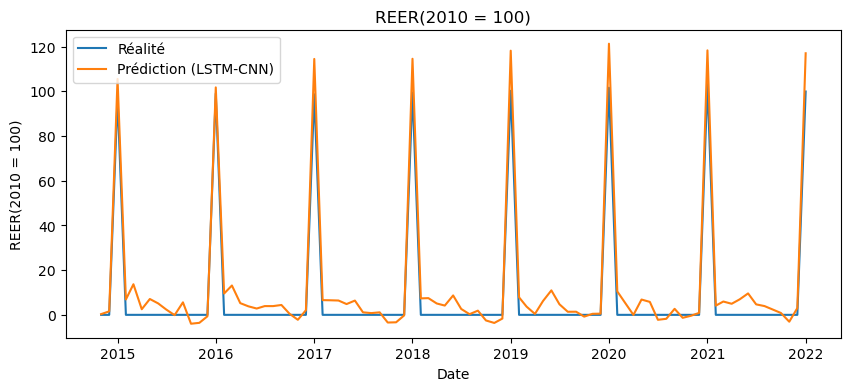

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


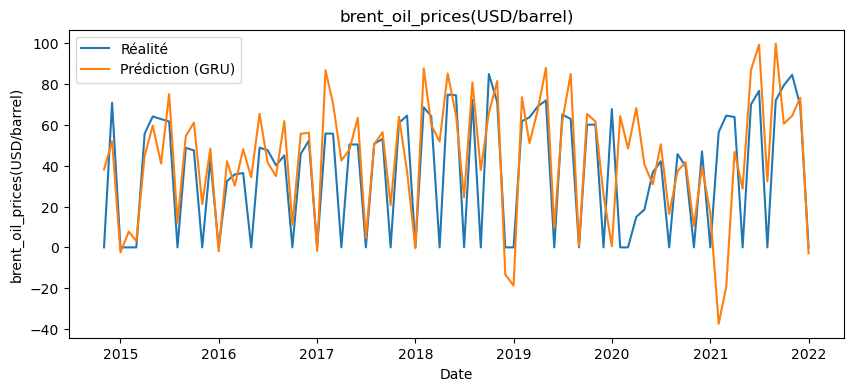

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


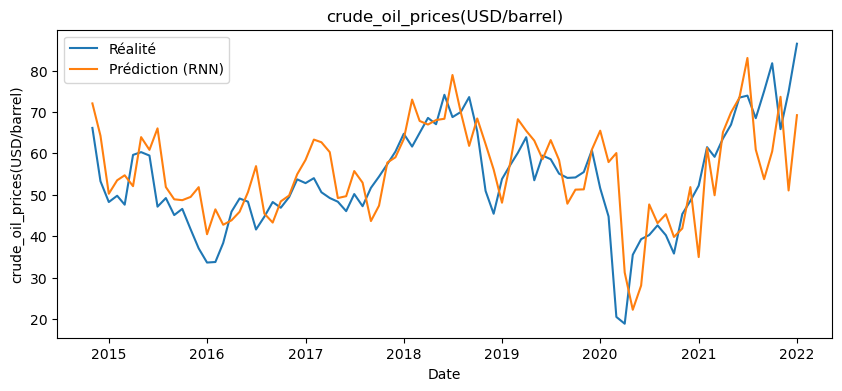

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


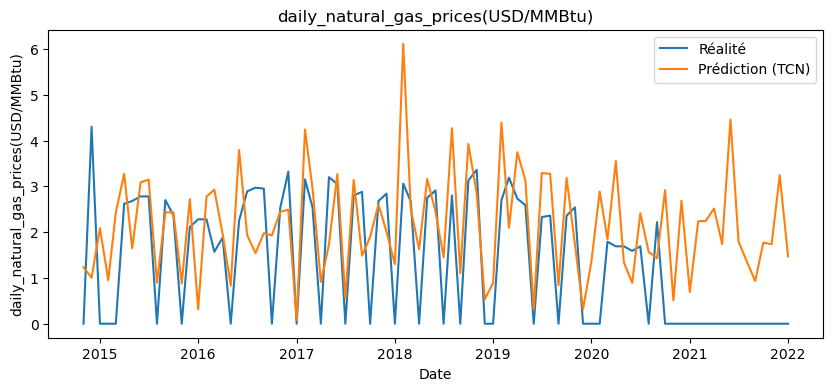

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


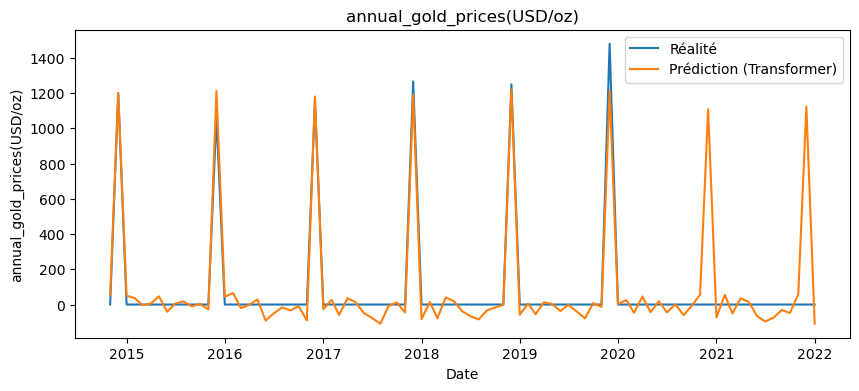

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


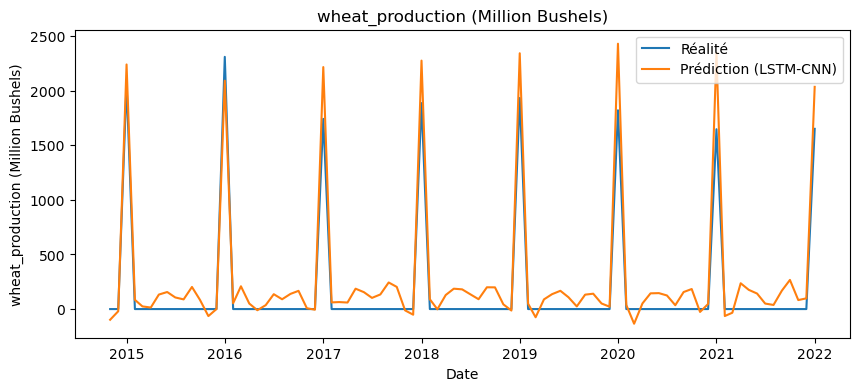

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


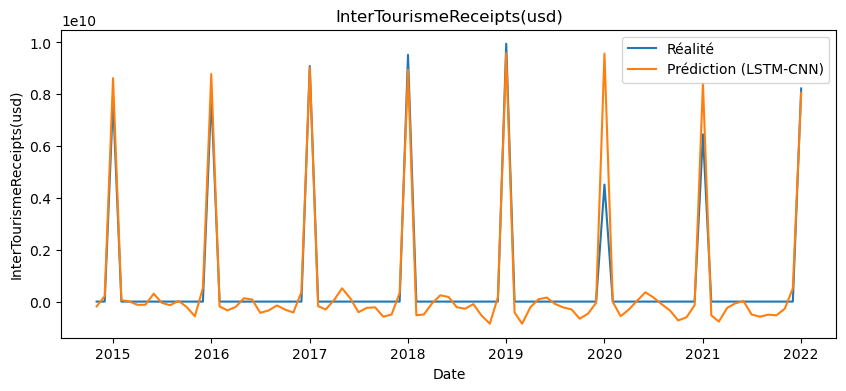

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


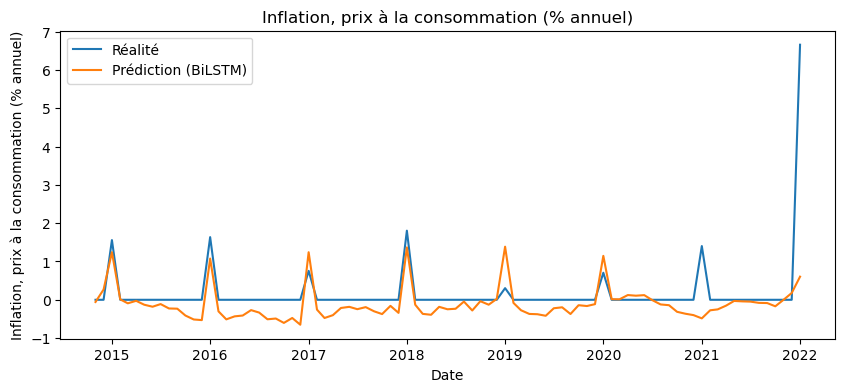

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


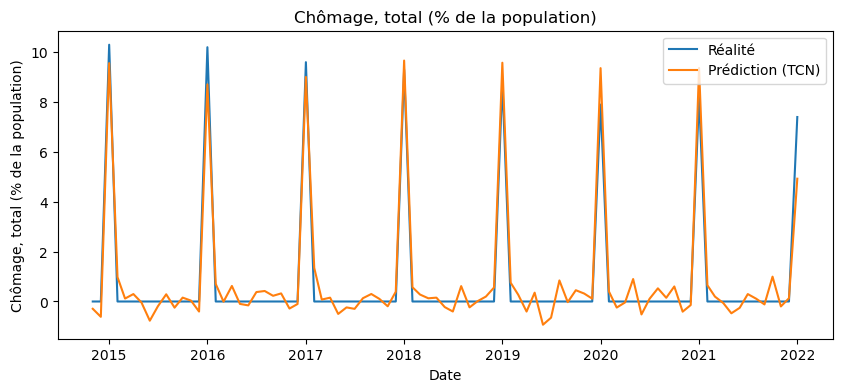

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


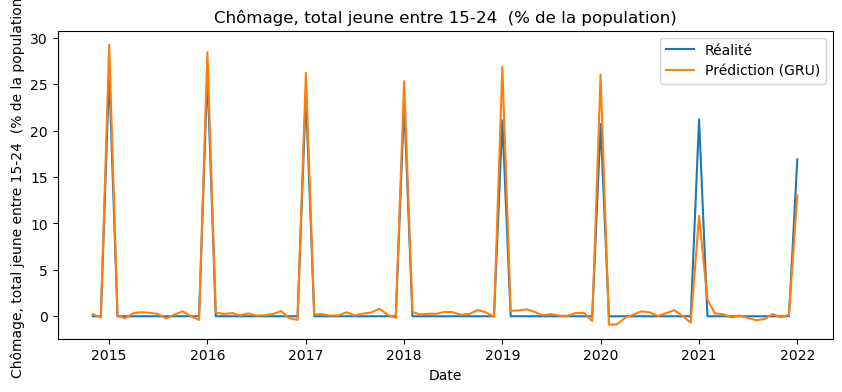

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


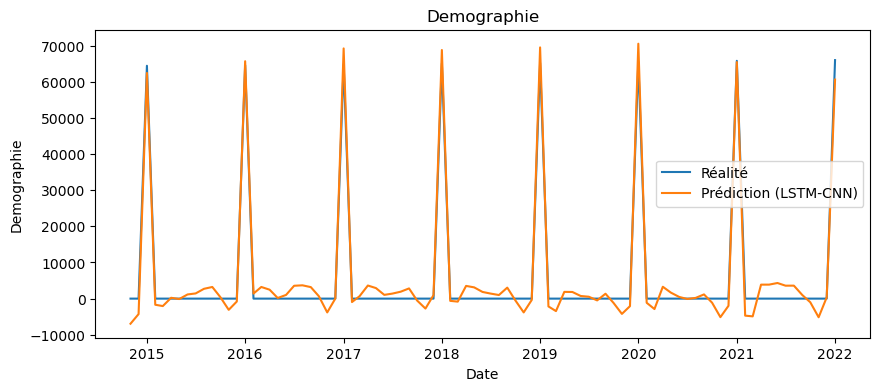

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


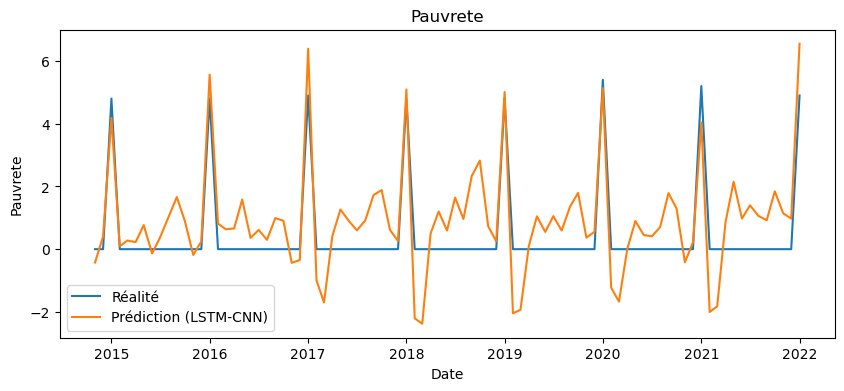

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


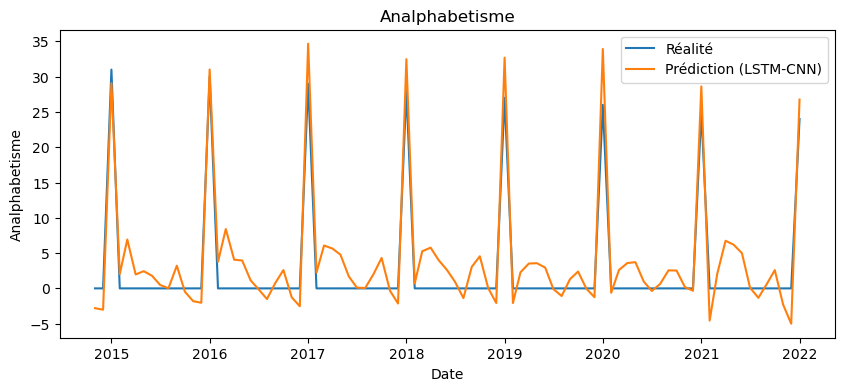

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


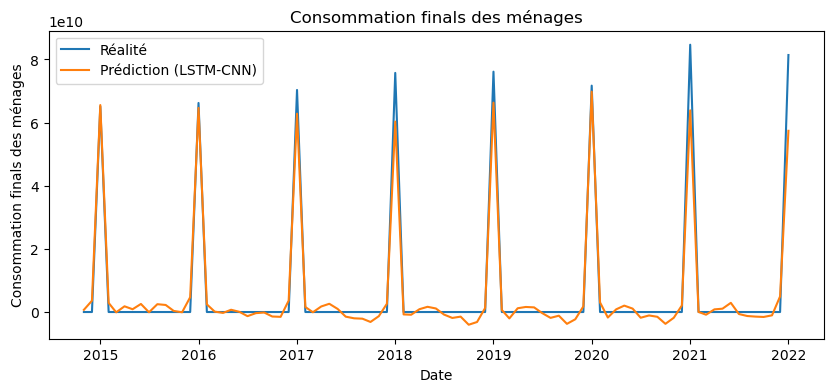

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


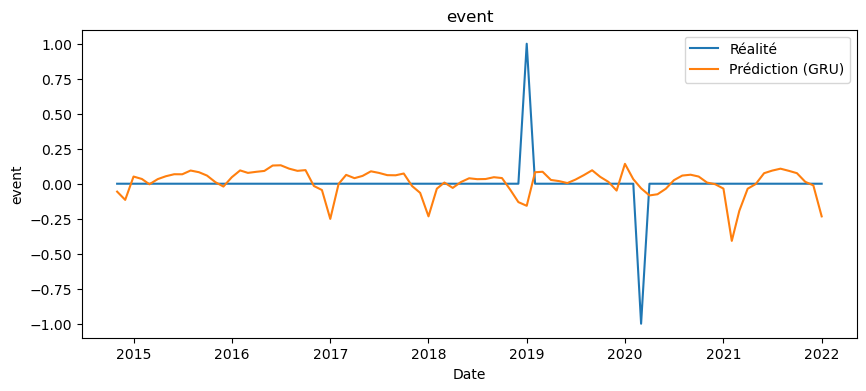

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


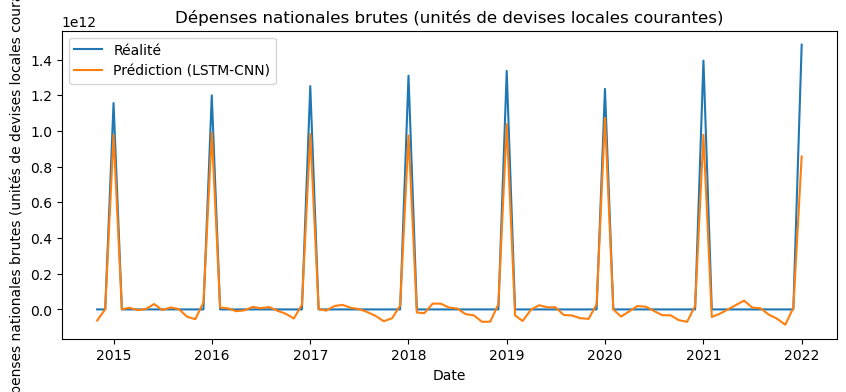

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


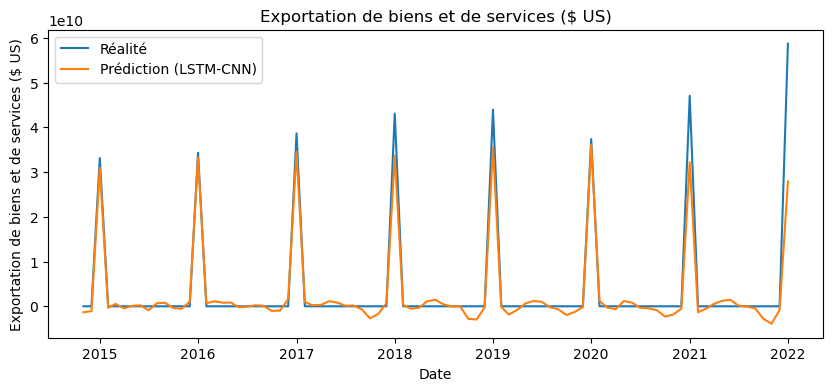

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


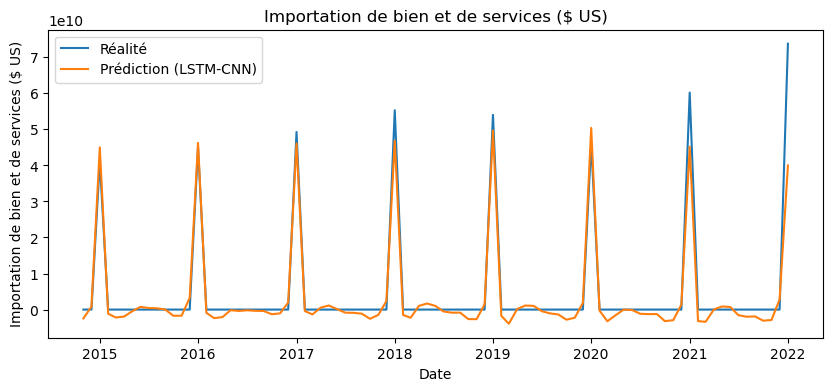

In [19]:
# Cell 13: Visualisation des prédictions pour chaque indicateur

# Utiliser tout l’index de test_df, pas à partir de 30
dates = test_df.index

# y_true calculé en Cell 12 (shape == len(dates) x n_features)
# On le reconstruit au besoin :
target_dims = len(num_cols)
mins   = scaler.min_[:target_dims]
scales = scaler.scale_[:target_dims]
y_true = (y_test - mins) / scales

for i, col in enumerate(num_cols):
    # prédictions du meilleur modèle pour cette colonne
    m = final_models[best_model_per_col[col]]
    preds_scaled = m.predict(X_test)[:, i]
    preds = (preds_scaled - mins[i]) / scales[i]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, y_true[:, i], label='Réalité')
    plt.plot(dates, preds,     label=f'Prédiction ({best_model_per_col[col]})')
    plt.title(col)
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()


In [28]:
# Générer les prédictions futures pour chaque indicateur avec le meilleur modèle

# Créer les dates futures pour 2024 et 2025
future_dates = pd.date_range(start='2023-01-01', end='2025-12-31', freq='M')
n_future = len(future_dates)

# On part de la dernière fenêtre de 30 jours du dataframe complet
SEQ = 30
last_window = df.iloc[-SEQ:].copy()

# Dictionnaire pour stocker les prédictions
predictions = {col: [] for col in num_cols}

# Pour chaque indicateur, générer les prédictions futures
for i, indicator in enumerate(num_cols):
    # Trouver le nom du meilleur modèle pour cet indicateur
    model_name = best_model_per_col[indicator]
    model = final_models[model_name]

    # On va faire une prédiction autoregressive pour chaque mois futur
    # On travaille sur une copie de la dernière fenêtre
    window = last_window.copy()
    preds = []
    for date in future_dates:
        # Créer les features temporelles pour la nouvelle date
        month = date.month
        dow = date.dayofweek
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        dow_sin = np.sin(2 * np.pi * dow / 7)
        dow_cos = np.cos(2 * np.pi * dow / 7)

        # Créer une nouvelle ligne avec les features
        new_row = pd.Series(0, index=df.columns)
        # On ne connaît pas les vraies valeurs futures, donc on met les dernières valeurs connues pour toutes les colonnes,
        # sauf pour les features temporelles qu'on met à jour
        for c in num_cols:
            new_row[c] = window.iloc[-1][c]
        new_row['month_sin'] = month_sin
        new_row['month_cos'] = month_cos
        new_row['dow_sin'] = dow_sin
        new_row['dow_cos'] = dow_cos

        # Ajouter la nouvelle ligne à la fenêtre temporaire
        temp_window = pd.concat([window, new_row.to_frame().T])
        temp_window = temp_window.iloc[-SEQ:]  # garder la taille de la fenêtre

        # Mise à l'échelle
        X_input = scaler.transform(temp_window)
        X_input = X_input.reshape(1, SEQ, -1)

        # Prédire la prochaine valeur (toutes les colonnes)
        y_pred_scaled = model.predict(X_input, verbose=0)[0]
        # Inverser le scaling pour l'indicateur cible
        val = y_pred_scaled[i] / scales[i] + mins[i]
        preds.append(val)

        # Mettre à jour la fenêtre pour la prochaine itération
        # On remplace la colonne cible par la prédiction, les autres restent inchangées
        new_row[indicator] = val
        window = pd.concat([window, new_row.to_frame().T]).iloc[-SEQ:]

    predictions[indicator] = preds

# Créer un DataFrame avec toutes les prédictions
predictions_df = pd.DataFrame(predictions, index=future_dates)

# Ajouter une colonne de date au format YYYY-MM
predictions_df['Date'] = predictions_df.index.strftime('%Y-%m')

# Réorganiser les colonnes pour avoir la date en premier
cols = ['Date'] + [col for col in predictions_df.columns if col != 'Date']
predictions_df = predictions_df[cols]

# Sauvegarder les prédictions dans un fichier CSV
output_path = r'C:\Users\Mouhcine\Desktop\Projet TS Zouga\predictions_2023_2025.csv'
predictions_df.to_csv(output_path, index=False)

print("Aperçu des prédictions :")
display(predictions_df.head())
print(f"\nLes prédictions ont été sauvegardées dans : {output_path}")

C:\Users\Mouhcine\AppData\Local\Temp\ipykernel_4776\1531449599.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2294356059.17334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_row[c] = window.iloc[-1][c]
C:\Users\Mouhcine\AppData\Local\Temp\ipykernel_4776\1531449599.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-376377039.6869027' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_row[c] = window.iloc[-1][c]
C:\Users\Mouhcine\AppData\Local\Temp\ipykernel_4776\1531449599.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-173700607.02092358' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_row[c] = window.iloc[-1][c]
C:\Users\Mouhc

Aperçu des prédictions :


,Date,IDE(USD),REER(2010 = 100),brent_oil_prices(USD/barrel),crude_oil_prices(USD/barrel),daily_natural_gas_prices(USD/MMBtu),annual_gold_prices(USD/oz),wheat_production (Million Bushels),InterTourismeReceipts(usd),"Inflation, prix à la consommation (% annuel)","Chômage, total (% de la population)","Chômage, total jeune entre 15-24 (% de la population)",Demographie,Pauvrete,Analphabetisme,Consommation finals des ménages,event,Dépenses nationales brutes (unités de devises locales courantes),Exportation de biens et de services ($ US),Importation de bien et de services ($ US)
2023-01-31,2023-01,-3.763770e+08,-8.954560,-17.268674,105.107983,3.207756,-56.800890,-248.185985,-1.235793e+09,-0.891384,0.850507,-4.391629,-9608.628701,-2.881197,2.038834,-7.190141e+09,1.219666,-1.285146e+11,-5.638053e+09,-6.070557e+09
2023-02-28,2023-02,-1.737006e+08,-10.047707,-18.954544,113.818414,1.450744,66.823509,115.486691,-9.374644e+08,-1.027278,0.498281,-6.582189,-3078.501267,-1.226260,3.261321,-2.067606e+09,1.317020,-3.496240e+10,-3.661264e+09,-1.463308e+09
2023-03-31,2023-03,-1.393636e+08,-6.747585,-8.698564,131.843627,2.277020,157.331122,186.965325,-8.533027e+08,-1.085427,-0.602943,-8.976558,-5777.010806,-1.040894,-1.375386,-9.185716e+08,1.366124,-3.151069e+10,-3.468252e+09,-9.326489e+08
2023-04-30,2023-04,-1.755517e+08,-5.357860,20.713621,134.249827,2.418872,57.770601,198.274850,-8.280306e+08,-1.049791,-0.042204,-10.195277,-5169.281332,-1.086401,-0.874301,-2.947366e+09,1.341634,-9.189372e+10,-3.010570e+09,-3.627518e+09
2023-05-31,2023-05,-3.834059e+08,-4.402116,16.881070,136.193169,0.967133,-4.429835,174.701329,-1.136588e+09,-1.029143,-0.333671,-11.525860,-3071.987520,-0.845424,0.119257,-6.839151e+09,1.268457,-7.697543e+10,-2.815414e+09,-4.613932e+09



Les prédictions ont été sauvegardées dans : C:\Users\Mouhcine\Desktop\Projet TS Zouga\predictions_2023_2025.csv


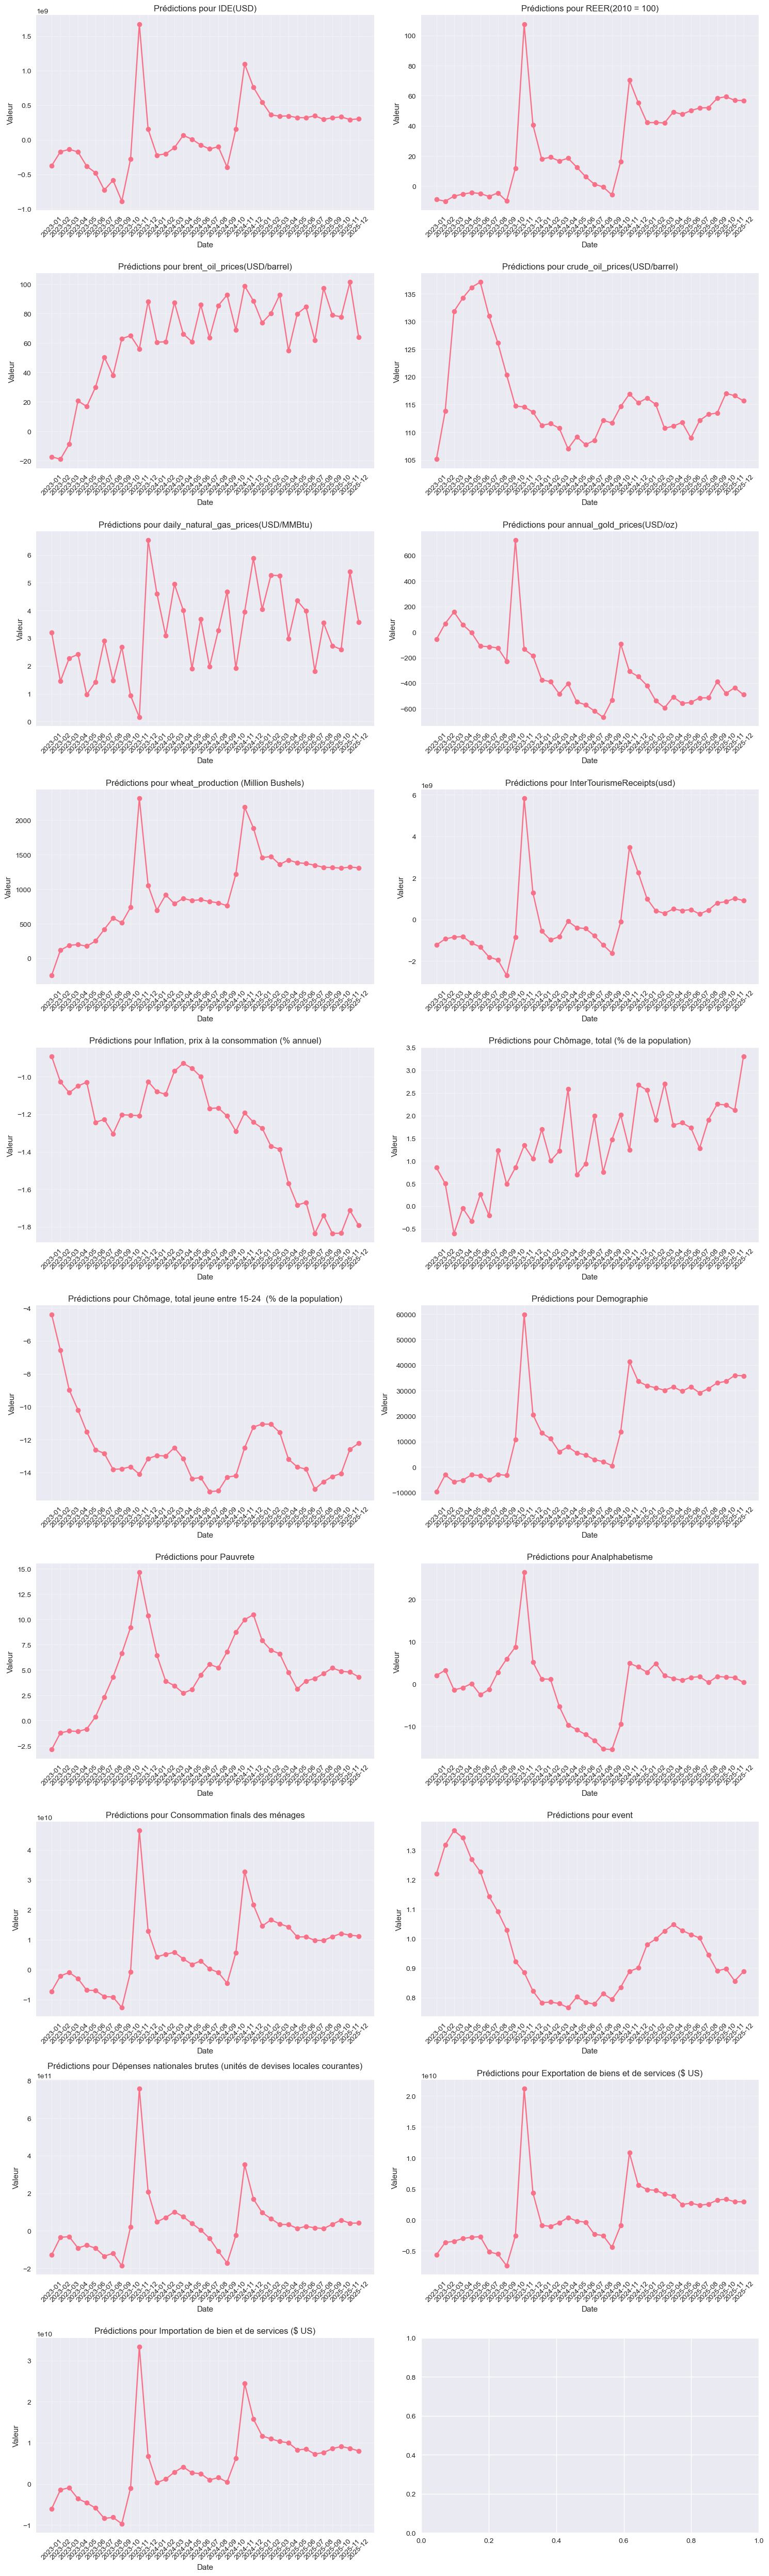

In [29]:
# Créer des visualisations pour chaque indicateur
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le style des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Calculer le nombre de lignes nécessaires pour les subplots
n_indicators = len(predictions_df.columns) - 1  # -1 pour exclure la colonne Date
n_rows = (n_indicators + 1) // 2  # 2 graphiques par ligne

# Créer la figure avec des subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Pour chaque indicateur
for idx, indicator in enumerate([col for col in predictions_df.columns if col != 'Date']):
    ax = axes[idx]
    
    # Tracer les prédictions
    ax.plot(predictions_df['Date'], predictions_df[indicator], 
            marker='o', linestyle='-', label='Prédictions')
    
    # Personnaliser le graphique
    ax.set_title(f'Prédictions pour {indicator}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Valeur')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
# Ajuster la mise en page
plt.tight_layout()
plt.show()